In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import matplotlib.patches as mpatches

In [3]:
planning_report_path = "Planning Parameter Report.xlsx"
inventory_report_path = "Inventory On Hand Report.xlsx"
current_openpurchase_path = "3. Current Open Purchase Orders.xlsx"
expected_lead_time_path = "4. Customer Expected Lead Times.xlsx"
usage_history_path = "Component Usage History (Last 52 Weeks).xlsx"
purchase_order_receipt_history_path =  "6. Purchase Order Receipt History (Last Two Years).xlsx"


planning_report = pd.read_excel(planning_report_path)
inventory_report = pd.read_excel(inventory_report_path)
current_openpurchase = pd.read_excel(current_openpurchase_path)
expected_lead_time = pd.read_excel(expected_lead_time_path)
usage_history = pd.read_excel(usage_history_path)
purchase_history_df = pd.read_excel(purchase_order_receipt_history_path)

In [9]:
#Replacing missing values with median
numeric_columns = ['Lead Time', 'OnHandQuantity', 'Safety Stock']
imputer = SimpleImputer(strategy='median')
for df in [planning_report, inventory_report, current_openpurchase, expected_lead_time, usage_history, purchase_history_df]:
    for column in numeric_columns:
        if column in df.columns:
            df[column] = imputer.fit_transform(df[[column]])

In [10]:
# Replacing 'date_column_1', 'date_column_2' with actual date columns 
date_columns = ['date_column_1', 'date_column_2']
for df in [planning_report, inventory_report, current_openpurchase, expected_lead_time, usage_history, purchase_history_df]:
    for column in date_columns:
        if column in df.columns:
            df[column] = pd.to_datetime(df[column], errors='coerce')

In [11]:
# Convert date columns to datetime format
purchase_history_df['PO PROMISED_DATE'] = pd.to_datetime(purchase_history_df['PO PROMISED_DATE'])
purchase_history_df['PO RECEIPT_DATE'] = pd.to_datetime(purchase_history_df['PO RECEIPT_DATE'])

# Filter out records that are unimportant for us (old PO's)
purchase_history_df = purchase_history_df[
    ~((purchase_history_df['PO PROMISED_DATE'].dt.year == 2000) |
      (purchase_history_df['PO PROMISED_DATE'].dt.year == 2002) | 
      (purchase_history_df['PO RECEIPT_DATE'].dt.year == 2000) |
      (purchase_history_df['PO REQUESTED DATE'].dt.year == 2000) |
      (purchase_history_df['PO REQUESTED DATE'].dt.year == 2002) |
      (purchase_history_df['PO PROMISED_DATE'].dt.year == 2020) |
     (purchase_history_df['PO REQUESTED DATE'].dt.year == 2020) 
)]

# Calculate the difference between promised and actual receipt dates in days
purchase_history_df['Lead_Time_Difference'] = (purchase_history_df['PO RECEIPT_DATE'] - purchase_history_df['PO PROMISED_DATE']).dt.days

# Summarize
# Negative values indicate early delivery, positive values indicate late delivery, and zero means on-time delivery
summary = purchase_history_df['Lead_Time_Difference'].describe()

# Count how often deliveries were on time, early, or late
on_time = purchase_history_df[purchase_history_df['Lead_Time_Difference'] == 0].shape[0]
early = purchase_history_df[purchase_history_df['Lead_Time_Difference'] < 0].shape[0]
late = purchase_history_df[purchase_history_df['Lead_Time_Difference'] > 0].shape[0]

summary, on_time, early, late


(count    29320.000000
 mean        -4.032538
 std         14.766418
 min       -372.000000
 25%         -7.000000
 50%         -2.000000
 75%          0.000000
 max        805.000000
 Name: Lead_Time_Difference, dtype: float64,
 4815,
 19155,
 5350)

In [12]:
#Testing on LTDiff numbers
items_with_large_lead_time_diff = purchase_history_df[purchase_history_df['Lead_Time_Difference'] > 500]
items_with_large_lead_time_diff

,PO_NUMBER,PO_LINE,New_Item_Number,SITE_LOCATION,QTY_RECEIVED,VENDOR_ID,New Vendor Name,PO_CREATION_DATE,PO REQUESTED DATE,PO PROMISED_DATE,PO RECEIPT_DATE,COMMODITY_FAMILY,COMMODITY_TEAM,VENDOR COUNTRY,ACTUAL_LEADTIME,Unit_Of_Measure,PO_Unit_Price,Currency,Lead_Time_Difference
19520,4277000086,17,EMR-664897,Emerson,400,150006221,Precision Craftsmen,2021-03-04,2021-03-05,2021-03-05,2023-05-19,STAINLESS PRODUCT,STEEL,United States,577,Foot,1.1,USD,805


The mean value being negative and the 75% quantile being zero suggest that a substantial portion of the orders are delivered on or before the promised date.
The extremely high max value (8035 days late) could potentially be a data error or a very extreme case and might merit further investigation, especially if it affects any decision-making processes based on this data.
The distribution of lead times indicates a general trend toward early delivery, with a significant number of orders also arriving on time. However, the presence of some late deliveries and the wide range in the standard deviation highlight variability in the supply chain process.

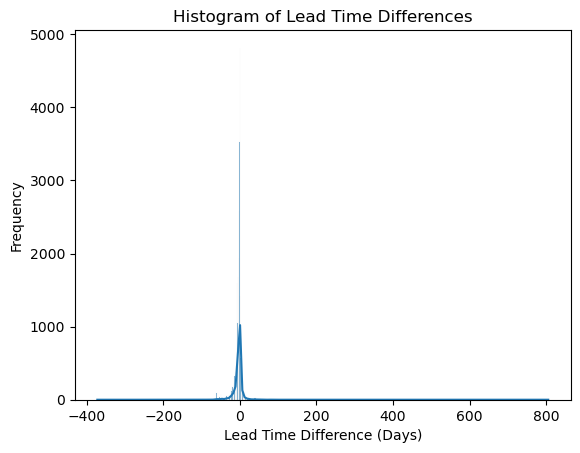

In [13]:
# Visualizations
sns.histplot(purchase_history_df['Lead_Time_Difference'].dropna(), kde=True)
plt.title('Histogram of Lead Time Differences')
plt.xlabel('Lead Time Difference (Days)')
plt.ylabel('Frequency')
plt.show()


Highly skewed distribution with a significant concentration of values at the lower end of the lead time difference axis (near zero). This suggests that most of the deliveries were on time or only slightly early/late.The x-axis extends to over 8000 days, which is quite long for any standard delivery schedule and suggests the presence of extreme outliers.

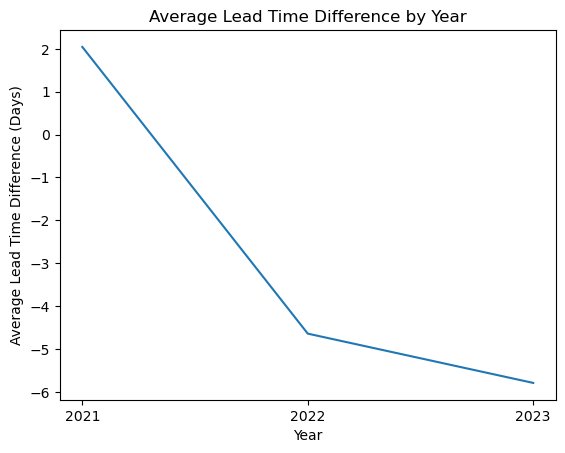

In [14]:
# Create a new column for the year of the promised date
purchase_history_df['Year'] = purchase_history_df['PO PROMISED_DATE'].dt.year

# Filter out the year 2000
filtered_df = purchase_history_df[purchase_history_df['Year'] != 2000]

# Aggregate mean lead time difference by year from the filtered DataFrame
average_lead_time_by_year = filtered_df.groupby('Year')['Lead_Time_Difference'].mean().reset_index()

# Plotting the trend over years using the filtered data
sns.lineplot(data=average_lead_time_by_year, x='Year', y='Lead_Time_Difference')
plt.title('Average Lead Time Difference by Year')
plt.xlabel('Year')
plt.ylabel('Average Lead Time Difference (Days)')
plt.xticks(average_lead_time_by_year['Year'].unique())  
plt.show()


The significant decline suggests that lead times have improved considerably over the years, meaning that the gap between promised and actual receipt dates has decreased. The steep fall to near zero may imply that by 2015 and onwards, deliveries are happening much closer to their promised dates on average, which could indicate improvements in supply chain efficiency, better forecasting, vendor management, or order processing systems.

However, such a dramatic change, especially the sharp fall to near zero, warrants a closer look to ensure there are no data anomalies, such as incorrect data entries, a change in how data is recorded, or if exceptionally late deliveries have ceased. 

In [15]:
# Missing Values Check
print(purchase_history_df['PO PROMISED_DATE'].isnull().sum())
print(purchase_history_df['PO RECEIPT_DATE'].isnull().sum())

# Checking for outliers in 'Lead_Time_Difference' that may skew the average
print(purchase_history_df['Lead_Time_Difference'].sort_values().head())
print(purchase_history_df['Lead_Time_Difference'].sort_values().tail())


0
0
10906   -372
13038   -221
12812   -180
21163   -174
4921    -155
Name: Lead_Time_Difference, dtype: int64
26932    286
2087     293
27264    358
21719    367
19520    805
Name: Lead_Time_Difference, dtype: int64


The data does not contain any missing dates, which is good for data integrity.
The presence of extremely negative and positive values in 'Lead_Time_Difference' suggests outliers or potential data entry errors. The negative values suggest early deliveries, with the earliest being almost a year ahead of schedule

In [16]:
#Investigating Early Deliveries
early_delivery_threshold = -30
early_deliveries = purchase_history_df[purchase_history_df['Lead_Time_Difference'] < early_delivery_threshold]
early_deliveries_sorted = early_deliveries.sort_values(by='Lead_Time_Difference', ascending=True)
early_deliveries_sorted[['PO PROMISED_DATE', 'PO RECEIPT_DATE', 'Lead_Time_Difference']]


,PO PROMISED_DATE,PO RECEIPT_DATE,Lead_Time_Difference
10906,2023-12-12,2022-12-05,-372
13038,2022-12-26,2022-05-19,-221
12812,2023-11-28,2023-06-01,-180
21163,2023-07-17,2023-01-24,-174
4921,2022-12-14,2022-07-12,-155
...,...,...,...
25610,2023-03-06,2023-02-03,-31
11206,2022-01-21,2021-12-21,-31
10782,2022-12-19,2022-11-18,-31
5209,2022-08-01,2022-07-01,-31


In [17]:
# Filter data for the years where average lead time is near zero
recent_years = average_lead_time_by_year[average_lead_time_by_year['Lead_Time_Difference'] < 1]
recent_data = purchase_history_df[purchase_history_df['Year'].isin(recent_years['Year'])]
recent_data


,PO_NUMBER,PO_LINE,New_Item_Number,SITE_LOCATION,QTY_RECEIVED,VENDOR_ID,New Vendor Name,PO_CREATION_DATE,PO REQUESTED DATE,PO PROMISED_DATE,PO RECEIPT_DATE,COMMODITY_FAMILY,COMMODITY_TEAM,VENDOR COUNTRY,ACTUAL_LEADTIME,Unit_Of_Measure,PO_Unit_Price,Currency,Lead_Time_Difference,Year
2,4277006276,3,EMR-100077,Emerson,4,150241733,Precision Techworks,2022-01-27,2022-02-10,2022-02-10,2022-02-10,"PURCHASED TOOL, PART, AND ASSEMBLY",DIVISION MANAGED,United States,14,Each,293.00,USD,0,2022
3,4277009627,6,EMR-100077,Emerson,4,150241733,Precision Techworks,2022-09-01,2022-09-15,2022-09-15,2022-09-16,"PURCHASED TOOL, PART, AND ASSEMBLY",DIVISION MANAGED,United States,15,Each,293.00,USD,1,2022
6,4277006271,1,EMR-1001,Emerson,1,150241871,Infinite Technologies,2022-01-27,2022-02-09,2022-02-09,2022-02-08,"PURCHASED TOOL, PART, AND ASSEMBLY",DIVISION MANAGED,United States,12,Each,27.79,USD,-1,2022
7,4277007930,1,EMR-1001,Emerson,5,150241871,Infinite Technologies,2022-05-12,2022-05-31,2022-05-31,2022-05-31,"PURCHASED TOOL, PART, AND ASSEMBLY",DIVISION MANAGED,United States,19,Each,37.55,USD,0,2022
8,4277008069,1,EMR-1001,Emerson,2,150241871,Infinite Technologies,2022-05-23,2022-06-17,2022-06-17,2022-06-17,"PURCHASED TOOL, PART, AND ASSEMBLY",DIVISION MANAGED,United States,25,Each,37.55,USD,0,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29328,4277011258,1,EMR-999327,Emerson,1,150241733,Precision Techworks,2022-12-19,2023-01-06,2023-01-06,2023-01-04,"PURCHASED TOOL, PART, AND ASSEMBLY",DIVISION MANAGED,United States,16,Each,51.00,USD,-2,2023
29329,4277012598,5,EMR-999327,Emerson,2,150241733,Precision Techworks,2023-03-24,2023-04-13,2023-04-13,2023-04-06,"PURCHASED TOOL, PART, AND ASSEMBLY",DIVISION MANAGED,United States,10,Each,51.00,USD,-7,2023
29330,4277013144,5,EMR-999327,Emerson,2,150241733,Precision Techworks,2023-05-04,2023-05-18,2023-05-18,2023-05-11,"PURCHASED TOOL, PART, AND ASSEMBLY",DIVISION MANAGED,United States,6,Each,51.00,USD,-7,2023
29331,4277013368,6,EMR-999327,Emerson,1,150241733,Precision Techworks,2023-05-23,2023-06-06,2023-06-06,2023-06-01,"PURCHASED TOOL, PART, AND ASSEMBLY",DIVISION MANAGED,United States,8,Each,45.00,USD,-5,2023


In [18]:
# Filter the recent_data for early deliveries
early_deliveries_recent = recent_data[recent_data['Lead_Time_Difference'] < 0]
early_deliveries_recent[['PO PROMISED_DATE', 'PO RECEIPT_DATE', 'Lead_Time_Difference', 'New Vendor Name', 'COMMODITY_FAMILY']]


,PO PROMISED_DATE,PO RECEIPT_DATE,Lead_Time_Difference,New Vendor Name,COMMODITY_FAMILY
6,2022-02-09,2022-02-08,-1,Infinite Technologies,"PURCHASED TOOL, PART, AND ASSEMBLY"
11,2022-08-04,2022-07-05,-30,Infinite Technologies,"PURCHASED TOOL, PART, AND ASSEMBLY"
17,2023-08-04,2023-08-01,-3,Infinite Technologies,"PIPE, VALVE, AND FITTING"
19,2023-06-22,2023-06-21,-1,Infinite Technologies,"PIPE, VALVE, AND FITTING"
20,2023-06-30,2023-06-23,-7,Infinite Technologies,"PIPE, VALVE, AND FITTING"
...,...,...,...,...,...
29328,2023-01-06,2023-01-04,-2,Precision Techworks,"PURCHASED TOOL, PART, AND ASSEMBLY"
29329,2023-04-13,2023-04-06,-7,Precision Techworks,"PURCHASED TOOL, PART, AND ASSEMBLY"
29330,2023-05-18,2023-05-11,-7,Precision Techworks,"PURCHASED TOOL, PART, AND ASSEMBLY"
29331,2023-06-06,2023-06-01,-5,Precision Techworks,"PURCHASED TOOL, PART, AND ASSEMBLY"


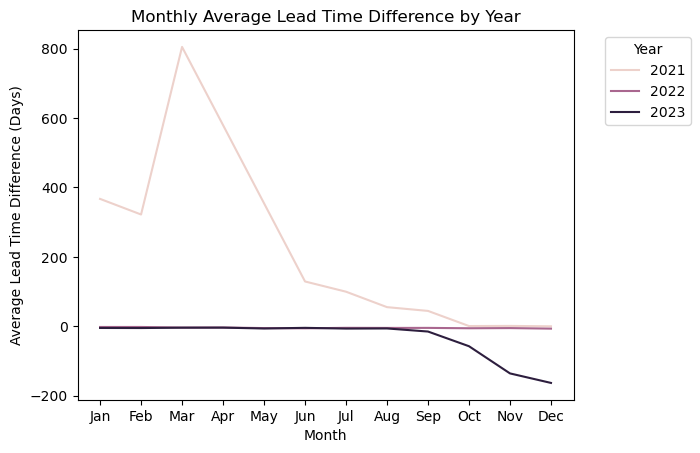

In [19]:
#Analyzing Monthly Trend
purchase_history_df['Month'] = purchase_history_df['PO PROMISED_DATE'].dt.month
monthly_lead_time_by_year = purchase_history_df.groupby(['Year', 'Month'])['Lead_Time_Difference'].mean().reset_index()
sns.lineplot(data=monthly_lead_time_by_year, x='Month', y='Lead_Time_Difference', hue='Year')
plt.title('Monthly Average Lead Time Difference by Year')
plt.xlabel('Month')
plt.ylabel('Average Lead Time Difference (Days)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


2000 or 2002 staying consistently high across all months, this could signify data issues or that these years had exceptionally high lead time differences. More recent years like 2021, 2022, and 2023 seem to have a much lower average lead time difference, suggesting improved delivery performance or, again, changes in how data is recorded or processed.

In [20]:
# upper and lower bounds using mean and standard deviation
mean = purchase_history_df['Lead_Time_Difference'].mean()
std = purchase_history_df['Lead_Time_Difference'].std()
lower_bound = mean - (2 * std)
upper_bound = mean + (2 * std)

# Filter outliers
std_outliers_df = purchase_history_df[(purchase_history_df['Lead_Time_Difference'] < lower_bound) | (purchase_history_df['Lead_Time_Difference'] > upper_bound)]

#summary of outlier suppliers
std_outlier_suppliers_summary = std_outliers_df['New Vendor Name'].value_counts()

print(std_outlier_suppliers_summary)


Omega Fabrications            122
Crystal Craftsmen             115
Apollo Metalworks             115
Sovereign Solutions           105
Echelon Engineering            50
                             ... 
Neptune Engineering             1
StellarTech Innovations         1
Summit Manufacturing Group      1
Elemental Innovations           1
Empire Engineering              1
Name: New Vendor Name, Length: 72, dtype: int64


#Comments
The vendor "QMI, INC." appears most frequently in the list of outliers, with 8 occurrences, indicating they may have a consistent issue with lead time deviations.
"TURPEN AND ASSOCIATES" appears with 2 outlier occurrences.
Several other vendors appear once, indicating fewer instances of extreme lead time differences.

Implications:
The output suggests that specific vendors are more often associated with extreme lead times. This could point to potential issues with certain suppliers or specific items that are prone to delivery issues.
The vendor "QMI, INC." might require further investigation to understand the reason behind the frequent extreme lead times. It could be due to logistical challenges, data entry errors, or other operational issues.
Since the threshold for outliers was set arbitrarily at two standard deviations from the mean, this may need to be adjusted based on industry standards or the specific context of the business to better capture what is considered an outlier.

In [21]:
# Calculate Q1, Q3, and IQR
Q1 = purchase_history_df['Lead_Time_Difference'].quantile(0.25)
Q3 = purchase_history_df['Lead_Time_Difference'].quantile(0.75)
IQR = Q3 - Q1
# upper and lower bounds using IQR
lower_bound_iqr = Q1 - (1.5 * IQR)
upper_bound_iqr = Q3 + (1.5 * IQR)
# Filter outliers
iqr_outliers_df = purchase_history_df[(purchase_history_df['Lead_Time_Difference'] < lower_bound_iqr) | (purchase_history_df['Lead_Time_Difference'] > upper_bound_iqr)]
# summary of outlier suppliers
iqr_outlier_suppliers_summary = iqr_outliers_df['New Vendor Name'].value_counts()
print(iqr_outlier_suppliers_summary)


Omega Fabrications            959
Apollo Metalworks             144
Crystal Craftsmen             144
Sovereign Solutions           132
Apex Manufacturing Co.        117
                             ... 
Summit Manufacturing Group      1
Summit Systems Group            1
Visionary Ventures              1
StellarTech Solutions Ltd.      1
Dynamic Metalworks Inc.         1
Name: New Vendor Name, Length: 88, dtype: int64


#Comments
"QMI, INC." is listed with the highest number of outliers, 1,168, which is significantly more than any other vendor. This could indicate consistent issues with their lead times.
Other vendors like "TYCON ALLOY INDUSTRIES HONG KONG CO LTD" and "T AND L FOUNDRY INC" also appear but with far fewer outliers.
There are 88 vendors in total listed with outlier occurrences.


# Outstanding Orders

In [25]:
from datetime import datetime

In [26]:
#Find total sum of PO's cost per Vendor
current_openpurchase['PROMISED DATE'] = pd.to_datetime(current_openpurchase['PROMISED DATE'])
# Filter orders that are overdue (where PROMISED DATE is before today) and not from the year 2000
today = datetime.now()
overdue_orders = current_openpurchase[
    (current_openpurchase['PROMISED DATE'] < today) &
    (current_openpurchase['PROMISED DATE'].dt.year != 2000)
]
# Replace 0 with 1 in 'Quantity Due'
overdue_orders['Adjusted Quantity Due'] = overdue_orders['Quantity Due'].replace(0, 1)
# Calculate Total Value = quantity * standard cost
overdue_orders['Total Value'] = overdue_orders['Adjusted Quantity Due'] * overdue_orders['PSC_StandardCostTotal']
# Count the number of overdue orders by supplier
overdue_orders_by_supplier = overdue_orders.groupby('Vendor Name')['Quantity Due'].count().reset_index(name='Overdue Orders Count')
overdue_orders_by_supplier['Total Value Sum'] = overdue_orders.groupby('Vendor Name')['Total Value'].sum().values
# Sort suppliers by the number of overdue orders in descending order
overdue_orders_by_supplier_sorted = overdue_orders_by_supplier.sort_values(by='Overdue Orders Count', ascending=False)
overdue_orders_by_supplier_sorted.head()


C:\Users\HP NOTES\AppData\Local\Temp\ipykernel_37868\262971415.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overdue_orders['Adjusted Quantity Due'] = overdue_orders['Quantity Due'].replace(0, 1)
C:\Users\HP NOTES\AppData\Local\Temp\ipykernel_37868\262971415.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overdue_orders['Total Value'] = overdue_orders['Adjusted Quantity Due'] * overdue_orders['PSC_StandardCostTotal']


,Vendor Name,Overdue Orders Count,Total Value Sum
47,"QMI, INC.",332,355675.863297
11,FASTENAL COMPANY,63,14162.474289
1,ANDY ANDERSON METAL WORKS INC,59,20687.638514
5,CHENGDU TIANCHENG PRECISION MACHINERY CO LTD,58,386896.377654
59,T AND L FOUNDRY INC,56,149797.777300


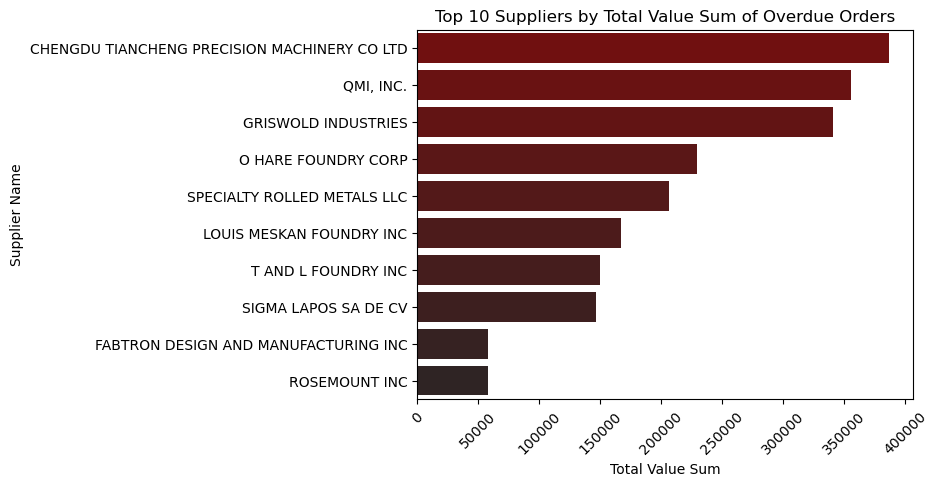

In [27]:
#Plot the Top 10 Suppliers with Highest Overdue Orders Total Sum
overdue_orders_by_supplier_sorted = overdue_orders_by_supplier.sort_values(by='Total Value Sum', ascending=False)
top_10_suppliers_by_value = overdue_orders_by_supplier_sorted.head(10)
palette_colors = sns.dark_palette("maroon", reverse=True, n_colors=len(top_10_suppliers_by_value))
sns.barplot(data=top_10_suppliers_by_value, x='Total Value Sum', y='Vendor Name', palette=palette_colors)
plt.title('Top 10 Suppliers by Total Value Sum of Overdue Orders')
plt.xlabel('Total Value Sum')
plt.ylabel('Supplier Name')
plt.xticks(rotation=45)  
plt.show()


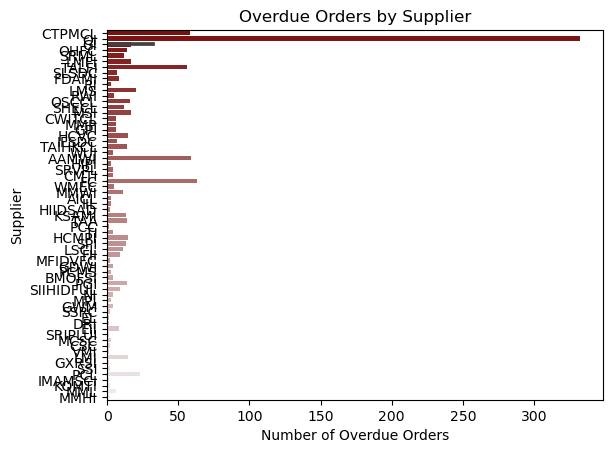

In [28]:
# Plot of the total number of PO's for Overdue Orders
palette_colors = sns.light_palette("darkred", reverse=True, n_colors=len(overdue_orders_by_supplier_sorted))
overdue_orders_by_supplier_sorted['Initials'] = overdue_orders_by_supplier_sorted['Vendor Name'].apply(lambda x: ''.join([word[0] for word in x.split()]))
sns.barplot(data=overdue_orders_by_supplier_sorted, x='Overdue Orders Count', y='Initials', palette=palette_colors)
plt.title('Overdue Orders by Supplier')
plt.xlabel('Number of Overdue Orders')
plt.ylabel('Supplier')
plt.show()


QMI, INC." is listed at the top with 14 overdue orders, which means this vendor has the highest number of overdue orders according to the dataset.
"ANDY ANDERSON METAL WORKS INC" has 13 overdue orders, almost as many as "QMI, INC.".
Other vendors like "FLAMECO INDUSTRIES INC", "PARAMOUNT GASKET INC", and "PRECISION COATINGS LLC" also have overdue orders but in smaller quantities.

In [29]:
overdue_orders_filtered = current_openpurchase[current_openpurchase['Quantity Due'] != 0]
overdue_orders_filtered.head()

,Vendor Name,Item,Buyer,Description,ABC,Full_LT,Product_Family,PROMISED DATE,REQUESTED DATE,Quantity Due,PSC_StandardCostTotal,PO CREATION DATE,Currency
0,ALPHA INVESTMENT CASTING LLC,NE8553003A0,JEFF,"SEAT ~ 3, WEBBED, CASTING",NaN,40.0,950,2024-03-22,2024-03-22,32,59.350655,2023-05-18 13:28:15,USD
1,ALPHA INVESTMENT CASTING LLC,NE8553004A0,JEFF,"SEAT ~ 6, WEBBED, CASTING",NaN,100.0,950,2024-03-22,2024-03-22,39,144.627518,2023-05-18 13:28:15,USD
2,ALPHA INVESTMENT CASTING LLC,NE8553006A0,JEFF,"SEAT ~ 10, 850/950, WEBBED, CASTING",NaN,100.0,950,2024-03-22,2024-03-22,26,155.630981,2023-05-18 13:28:15,USD
4,ANDY ANDERSON METAL WORKS INC,NE8567302A0,JEFF,"WALL ~ 12, FRONT, LOWER BODY",NaN,15.0,950,2024-01-22,2024-01-22,3,255.529999,2024-01-03 23:16:30,USD
5,ANDY ANDERSON METAL WORKS INC,NV10090155A0,JEFF,"ARM ~ COUNTERWEIGHT, 14.62 INCH LENGTH",NaN,40.0,221,2024-02-23,2024-02-23,20,17.958000,2024-01-03 23:16:31,USD


In [30]:
current_openpurchase

,Vendor Name,Item,Buyer,Description,ABC,Full_LT,Product_Family,PROMISED DATE,REQUESTED DATE,Quantity Due,PSC_StandardCostTotal,PO CREATION DATE,Currency
0,ALPHA INVESTMENT CASTING LLC,NE8553003A0,JEFF,"SEAT ~ 3, WEBBED, CASTING",NaN,40.0,950,2024-03-22,2024-03-22,32,59.350655,2023-05-18 13:28:15,USD
1,ALPHA INVESTMENT CASTING LLC,NE8553004A0,JEFF,"SEAT ~ 6, WEBBED, CASTING",NaN,100.0,950,2024-03-22,2024-03-22,39,144.627518,2023-05-18 13:28:15,USD
2,ALPHA INVESTMENT CASTING LLC,NE8553006A0,JEFF,"SEAT ~ 10, 850/950, WEBBED, CASTING",NaN,100.0,950,2024-03-22,2024-03-22,26,155.630981,2023-05-18 13:28:15,USD
3,ANDY ANDERSON METAL WORKS INC,NV10090155A0,JEFF,"ARM ~ COUNTERWEIGHT, 14.62 INCH LENGTH",NaN,40.0,221,2024-01-26,2024-01-26,0,17.958000,2023-12-18 19:28:50,USD
4,ANDY ANDERSON METAL WORKS INC,NE8567302A0,JEFF,"WALL ~ 12, FRONT, LOWER BODY",NaN,15.0,950,2024-01-22,2024-01-22,3,255.529999,2024-01-03 23:16:30,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1322,WENHUA MACHINERY ENTERPRISE CO,ERAA22610A0,JEFF,"BASE ~ EPRV, 24, ANSI, FORGED",NaN,100.0,2000,2024-05-10,2024-05-10,6,345.800507,2023-12-21 05:18:58,USD
1323,WUHAN UNITED JENSON,NV10090267A0,MARK,"BANK ASSY ~ 12, ALUMINUM EXTENSIBLE FRAME WITH...",NaN,110.0,5000,2024-04-01,2024-04-01,10,1643.166992,2023-12-19 17:25:56,USD
1324,WUHAN UNITED JENSON,NV10090295A0,MARK,"BANK ASSY ~ 2, ALUMINUM EXTENSIBLE FRAME WITH ...",NaN,110.0,5000,2024-04-01,2024-04-01,10,53.973656,2023-12-19 17:25:56,USD
1325,WUHAN UNITED JENSON,NV10090296A0,MARK,"BANK ASSY ~ 3, ALUMINUM EXTENSIBLE FRAME WITH ...",NaN,110.0,5000,2024-04-01,2024-04-01,10,70.407173,2023-12-19 17:25:56,USD


In [31]:
current_openpurchase['Quantity Due'].value_counts(dropna=False)

1      150
10     112
2      110
20      94
0       78
      ... 
146      1
439      1
61       1
550      1
38       1
Name: Quantity Due, Length: 90, dtype: int64

## Late Orders


In [32]:
# Filter the DataFrame for POs with a Lead_Time_Difference of more than 7
po_count_over_7 = (purchase_history_df['Lead_Time_Difference'] > 7).sum()
print(f"Number of POs with Lead Time Difference greater than 7: {po_count_over_7}")


Number of POs with Lead Time Difference greater than 7: 1362


In [33]:
# Count unique PO numbers for each vendor
pos_per_vendor = purchase_history_df.groupby('New Vendor Name').size()
print(pos_per_vendor)

New Vendor Name
Absolute Manufacturing             6
Alpha Machinery Group            132
AlphaTech Innovations             23
AlphaTech Manufacturing           29
AlphaTech Manufacturing Group     10
                                ... 
Visionary Ventures                17
Zenith Fabricators                29
Zenith Innovators                 58
Zenith Innovators Ltd.            15
Zenith Machine Works              28
Length: 106, dtype: int64


In [34]:
# Find PO's that are late by 7 days
late_entries = purchase_history_df[purchase_history_df['Lead_Time_Difference'] > 7]
late_counts_by_vendor = late_entries['New Vendor Name'].value_counts()
print("Number of 'late' entries by 'New Vendor Name':")
print(late_counts_by_vendor)


Number of 'late' entries by 'New Vendor Name':
Omega Fabrications            235
Stellar Structures Group      134
Dynamic Producers             134
Genesis Materials              77
Apex Manufacturing Co.         73
                             ... 
AlphaTech Manufacturing         1
Summit Manufacturing Group      1
Summit Systems Group            1
Quantum Precision Inc.          1
Zenith Innovators Ltd.          1
Name: New Vendor Name, Length: 83, dtype: int64


In [35]:
# Calculating Late percentage on a column
late_counts_by_vendor = late_counts_by_vendor.reindex(pos_per_vendor.index, fill_value=0)
late_percentage = late_counts_by_vendor / pos_per_vendor * 100  # Multiply by 100 to convert to percentage
vendors_df = pd.DataFrame({
    'Total POs': pos_per_vendor,
    'Late Count': late_counts_by_vendor,
    'Late Percentage': late_percentage
})
print("Vendor Analysis with Late Percentage:")
print(vendors_df)


Vendor Analysis with Late Percentage:
                               Total POs  Late Count  Late Percentage
New Vendor Name                                                      
Absolute Manufacturing                 6           1        16.666667
Alpha Machinery Group                132           5         3.787879
AlphaTech Innovations                 23          13        56.521739
AlphaTech Manufacturing               29           1         3.448276
AlphaTech Manufacturing Group         10           1        10.000000
...                                  ...         ...              ...
Visionary Ventures                    17           0         0.000000
Zenith Fabricators                    29           2         6.896552
Zenith Innovators                     58           1         1.724138
Zenith Innovators Ltd.                15           1         6.666667
Zenith Machine Works                  28           4        14.285714

[106 rows x 3 columns]


In [36]:
# Sort high to low late percentage (maybe for showing who is the worst in sending shipments
sorted_vendors_df = vendors_df.sort_values('Late Percentage', ascending=False)
print("Vendors sorted by Late Percentage (highest first):")
print(sorted_vendors_df)

Vendors sorted by Late Percentage (highest first):
                            Total POs  Late Count  Late Percentage
New Vendor Name                                                   
Element Craftsmen                  17          17       100.000000
Empyrean Industries                18          18       100.000000
Dynamic Creations Inc.             10           8        80.000000
Horizon Ventures Inc.              15           9        60.000000
AlphaTech Innovations              23          13        56.521739
...                               ...         ...              ...
Quantum Creations Ltd.              1           0         0.000000
Omega Manufacturing                 1           0         0.000000
StellarCraft Precision              3           0         0.000000
Paradigm Producers                 19           0         0.000000
StellarTech Solutions Ltd.          1           0         0.000000

[106 rows x 3 columns]


In [37]:
# Late PO's total price by Vendor
late_entries['Total_PO_Price'] = late_entries['PO_Unit_Price'] * late_entries['QTY_RECEIVED']
total_late_prices_by_vendor = late_entries.groupby('New Vendor Name')['Total_PO_Price'].sum()
print("Total price of late POs by 'New Vendor Name':")
print(total_late_prices_by_vendor)


Total price of late POs by 'New Vendor Name':
New Vendor Name
Absolute Manufacturing            2162.600
Alpha Machinery Group            13349.710
AlphaTech Innovations             8162.257
AlphaTech Manufacturing          33620.000
AlphaTech Manufacturing Group    35711.760
                                   ...    
Visionary Manufacturing           8319.600
Zenith Fabricators               57132.500
Zenith Innovators                  102.480
Zenith Innovators Ltd.             745.000
Zenith Machine Works              9079.000
Name: Total_PO_Price, Length: 83, dtype: float64


C:\Users\HP NOTES\AppData\Local\Temp\ipykernel_37868\2103356793.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  late_entries['Total_PO_Price'] = late_entries['PO_Unit_Price'] * late_entries['QTY_RECEIVED']


In [38]:
late_entries.columns

Index(['PO_NUMBER', 'PO_LINE', 'New_Item_Number', 'SITE_LOCATION',
       'QTY_RECEIVED', 'VENDOR_ID', 'New Vendor Name', 'PO_CREATION_DATE',
       'PO REQUESTED DATE', 'PO PROMISED_DATE', 'PO RECEIPT_DATE',
       'COMMODITY_FAMILY', 'COMMODITY_TEAM', 'VENDOR COUNTRY',
       'ACTUAL_LEADTIME', 'Unit_Of_Measure', 'PO_Unit_Price', 'Currency',
       'Lead_Time_Difference', 'Year', 'Month', 'Total_PO_Price'],
      dtype='object')

C:\Users\HP NOTES\AppData\Local\Temp\ipykernel_37868\2114699912.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  late_entries['Total_PO_Price'] = late_entries['PO_Unit_Price'] * late_entries['QTY_RECEIVED']


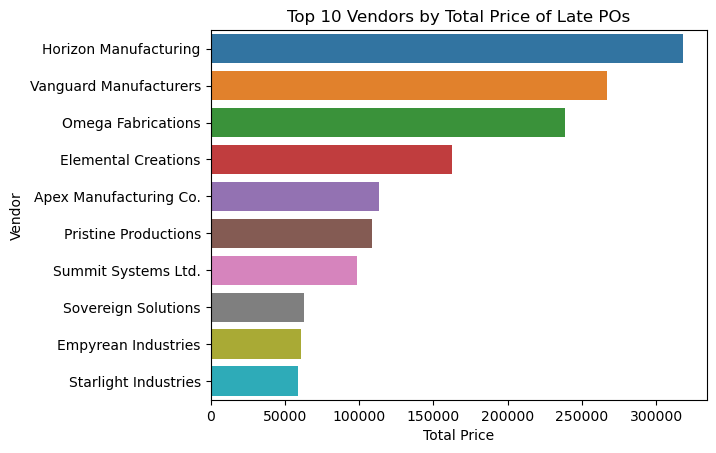

In [39]:
#Plot top 10 Vendors with Highest Price for Late PO's
late_entries['Total_PO_Price'] = late_entries['PO_Unit_Price'] * late_entries['QTY_RECEIVED']
total_late_prices_by_vendor = late_entries.groupby('New Vendor Name')['Total_PO_Price'].sum().reset_index()
total_late_prices_by_vendor = total_late_prices_by_vendor.sort_values(by='Total_PO_Price', ascending=False).head(10)
sns.barplot(data=total_late_prices_by_vendor, x='Total_PO_Price', y='New Vendor Name')
plt.title('Top 10 Vendors by Total Price of Late POs')
plt.xlabel('Total Price')
plt.ylabel('Vendor')
plt.show()

In [40]:
#Late PO's total sum
total_late_price = late_entries['Total_PO_Price'].sum()
print("Sum of Total Price for all late POs:")
print(total_late_price)

Sum of Total Price for all late POs:
2479824.196332


In [41]:
#Find mean days of late PO's 
late_entries = purchase_history_df[purchase_history_df['Lead_Time_Difference'] > 7]
mean_late_days = late_entries['Lead_Time_Difference'].mean()
print("Mean number of late days for POs:")
print(mean_late_days)

Mean number of late days for POs:
24.51101321585903
